<a href="https://colab.research.google.com/github/Noznoc/access-classifier/blob/main/WIP_Exterior_Accessibility_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating CNNs for Identifying Building Enterances
**Author:** Alex Lane and Julia Conzon <br>
**Date created:** 2021/03/18<br>
**Description:** Training an image classifier from scratch on the Mapillary API imagery collected on building enterances.

## Setup


Import the necessary Python packages for evaluation.

In [ ]:
import sys # for importing directory
import tensorflow as tf # for modeling
from tensorflow import keras # for modeling
from keras.models import Sequential # following Wu et al. (2019) sequential model was used
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation
import matplotlib.pyplot as plt # for visualizing images
import numpy as np

## Load the data: "Accessible" and "Inaccessible" dataset

Compile data from the Mapillary API, [scripts accessible in another notebook]()

Confirm folder of Mapillary API imagery exists. Subfolders should be `Accessible` and `Inaccessible`, which each contain the images that represent the category.


In [ ]:
!ls OSM_And_Mapillary_Sequence_Dataset
# Create two folders: "Test" and "Train" each with "Accessible" and "Inaccessible" folders
# "Test" will have 15% of dataset, 127 images with 63 "Accessible" and 64 "Inaccessible"
# "Train" will have 85% of dataset, 717 images with 358 "Accessible" and 359 "Inaccessible"

import os, random
import shutil

# Function that randomly moves image files based on source directory, destination directory and number of files wanting to move
def randomly_move_imgs(src_dir, dst_dir, n):
  file_list = os.listdir(src_dir)
  for j in range(n):
    img = random.choice(file_list)
    shutil.move(src_dir + img, dst_dir)

# Read "OSM_And_Mapillary_Sequence_Dataset/Accessible" folder randomly select 63 and move to "Test/Accessible" folder
n = 10 # 64
src_dir = "./OSM_And_Mapillary_Sequence_Dataset/Train/Accessible/"
dst_dir = "./OSM_And_Mapillary_Sequence_Dataset/Test/Accessible"
# randomly_move_imgs(src_dir, dst_dir, n)

# Read "OSM_And_Mapillary_Sequence_Dataset/Inaccessible" folder and randomly select 64 and move to "Test/Inaccessible" folder
n = 10 #63
src_dir = "./OSM_And_Mapillary_Sequence_Dataset/Train/Inaccessible/"
dst_dir = "./OSM_And_Mapillary_Sequence_Dataset/Test/Inaccessible"
# randomly_move_imgs(src_dir, dst_dir, n)

Model  Test  Train


## Preprocess Data


Steps includes standardizing the images to the same size (`image_size`). 

Keras `seed` command is an optional parameter to offer a random seed for shuffling and transforming the images to augment the dataset. 

In [ ]:
image_size = (180, 180)
batch_size = 103#16


# Assign to a train dataset (85%)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "OSM_And_Mapillary_Sequence_Dataset/Train",
    validation_split=0.15,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'binary',
)

# Assign to a validation dataset (15%)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "OSM_And_Mapillary_Sequence_Dataset/Train",
    validation_split=0.15,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'binary',
)

# confirm classes
class_names = train_ds.class_names
print(class_names)

print(train_ds)
print(valid_ds)

Found 824 files belonging to 2 classes.
Using 701 files for training.
Found 824 files belonging to 2 classes.
Using 123 files for validation.
['Accessible', 'Inaccessible']
<BatchDataset shapes: ((None, 180, 180, 3), (None, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 180, 180, 3), (None, 1)), types: (tf.float32, tf.float32)>


## Visualize Data

Label 1 is "inaccessible" and label 0 is "accessible".


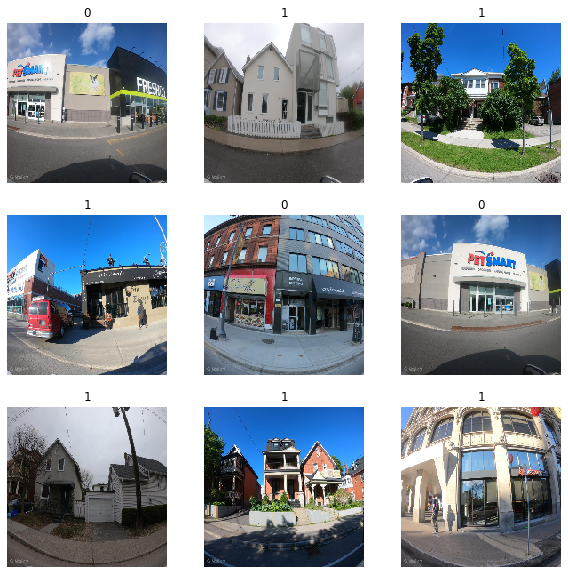

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Augmentation

Considering the small sample for training, the dataset will be augmented, that is randomly flipped horizontally, rotated, contrasted and zoomed.

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/


In [ ]:
data_augmentation = keras.Sequential(
    [
        # Reminder, the order in which transformations are called significantly 
        # affects the final augmentation.
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomTranslation(0.1,0.1),
        layers.experimental.preprocessing.RandomZoom(0.3),
        layers.experimental.preprocessing.RandomRotation(0.15),
        layers.experimental.preprocessing.RandomContrast(0.01),
        #layers.experimental.preprocessing.RandomHeight(0.5),
        #layers.experimental.preprocessing.RandomWidth(0.5),
        #layers.experimental.preprocessing.Resizing(180, 180),
    ]
)

Visualize the augmented samples:


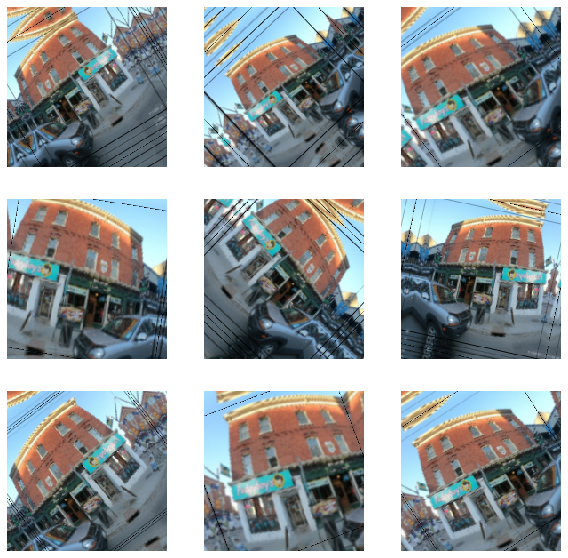

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Configure Dataset

Following documentation from Keras creator, François Chollet, use buffered prefetching to yield data from disk without having I/O becoming blocking:


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
valid_ds = valid_ds.prefetch(buffer_size=32)


## Build Model

Start off with a simple Sequential model, following Wu et al. (2019)



Tensor("rescaling_31/add:0", shape=(None, 180, 180, 3), dtype=float32)


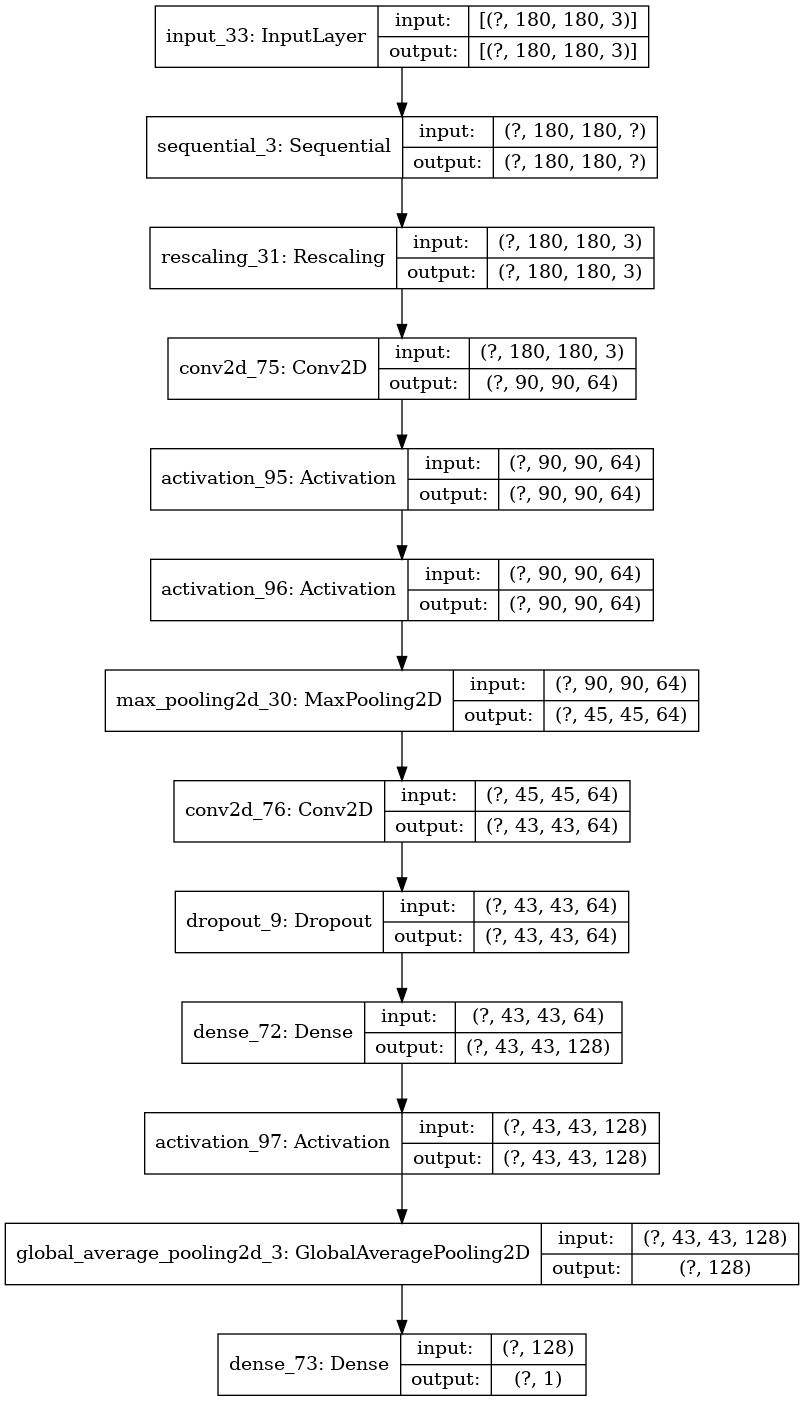

In [ ]:
# Model parameters
input_shape = image_size + (3,)
#input_shape = image_size + (1,)
num_classes = 2

# Initialize CNN2 (Wu et al 2019)
inputs = keras.Input(shape=input_shape) # establish inputs
layer = data_augmentation(inputs) # first "layer" is augmented images

layer = layers.experimental.preprocessing.Rescaling(1.0 / 255)(layer)
print(layer)

# Building blocks for CNN

# Step 1: Convolution and activation layers
layer = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(layer)
layer = Activation('relu')(layer)
#layer = Conv2D(filters=32, kernel_size=3)(layer)
layer = Activation('relu')(layer)

# Step 2: Pooling, 2 was selected based on Wu et al. 2019
layer = MaxPooling2D(pool_size = (2,2))(layer)

# Step 3: Convolutional layer
layer = Conv2D(filters=64, kernel_size=3)(layer)

# Step 4: Dropout used for CNN3 and CNN5
layer = Dropout(0.25)(layer)

# Step 5: Fully-connected layer
layer = Dense(128, activation='relu')(layer)
layer = Activation('relu')(layer)
#layer = Dense(num_classes, activation='relu')(layer)
layer = layers.GlobalAveragePooling2D()(layer)
outputs = Dense(1, activation='sigmoid')(layer) # or use sigmoid to view probability distribution

# Initialize model with building blocks
model = keras.Model(inputs, outputs)

# Plot model architecture
keras.utils.plot_model(model, to_file='model.png', rankdir='TR', show_shapes='True')

# Print summary of model
# model.summary()

# for layer in model.layers:
#     print(layer.output_shape)

# Train Model

SOLVED: It has to do with output layer, not input

Having errors, last relevant stackoverflow post below

https://stackoverflow.com/questions/63867887/is-incompatible-with-the-layer-expected-axis-1-of-input-shape-to-have-value-1

Note, the input shape is messed up, possibly due to batch size not evenly dividing the dataset

https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

https://stackoverflow.com/questions/54524124/dimension-mismatch-in-keras-during-model-fit

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("OSM_And_Mapillary_Sequence_Data/Model/Epochs/{epoch}.h5"),
]

# Compile CNN, following defaults for binary classification
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds)#, steps_per_epoch=len(train_ds)//16)

Epoch 1/30
7/7 [==============================] - 5s 658ms/step - loss: 0.6908 - accuracy: 0.5364 - val_loss: 0.6986 - val_accuracy: 0.4553
Epoch 2/30
7/7 [==============================] - 4s 542ms/step - loss: 0.6900 - accuracy: 0.5078 - val_loss: 0.6783 - val_accuracy: 0.5772
Epoch 3/30
7/7 [==============================] - 5s 661ms/step - loss: 0.6815 - accuracy: 0.5892 - val_loss: 0.6801 - val_accuracy: 0.5772
Epoch 4/30
7/7 [==============================] - 4s 604ms/step - loss: 0.6768 - accuracy: 0.5735 - val_loss: 0.6739 - val_accuracy: 0.5854
Epoch 5/30
7/7 [==============================] - 5s 702ms/step - loss: 0.6712 - accuracy: 0.6034 - val_loss: 0.6511 - val_accuracy: 0.6098
Epoch 6/30
7/7 [==============================] - 5s 663ms/step - loss: 0.6601 - accuracy: 0.5920 - val_loss: 0.6433 - val_accuracy: 0.5285
Epoch 7/30
7/7 [==============================] - 4s 600ms/step - loss: 0.6558 - accuracy: 0.6020 - val_loss: 0.6423 - val_accuracy: 0.6748
Epoch 8/30
7/7 [====

# Test Model



In [ ]:
img = keras.preprocessing.image.load_img(
    "./OSM_And_Mapillary_Sequence_Dataset/Test/Accessible/0009 A8-IT0RqrOz9YlybO7_UEg.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # create batch axis

#predictions = model.predict(img_array)
score = predictions[0]

print(
    "This image of building enterance is %.2f percent inaccessible and %.2f percent accessible."
    % (100 * (1 - score), 100 * score)
)

InvalidArgumentError: ignored